In [84]:
### plot SD tracks & TC tracks - Hurricane missions
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
from scipy.stats import pearsonr
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from values_to_colors import truncate_colormap
from convert_time import datetime_to_yearday

In [2]:
### SD position data info
year = np.array(['2021','2022','2023','2024'])
path_data = '/Users/chi/Documents/projects/sd-adcp-manipulate/merge_raw_files/data_Hurricane_SD_pos/'
filenames_all = np.sort( os.listdir(path_data) )
### retain the filenames wanted only
filenames = np.array([])
for file in filenames_all:
    if ('pos' in file) & ('.nc' in file):
        filenames = np.append(filenames, file)
print(len(filenames),'Files have "pos" & ".nc" in the',path_data)
print(filenames)

### load topography data
path_topo = '/Users/chi/Documents/Data/Topography/GEBCO_23_Jan_2025/'
ds_topo = nc.Dataset(path_topo+'gebco_2024_n50.0_s5.0_w-98.0_e-30.0.nc')
# print(ds_topo)
lon_topo = ds_topo.variables['lon'][:]
lat_topo = ds_topo.variables['lat'][:]
elevation = ds_topo.variables['elevation'][:]
print(lon_topo.shape, lat_topo.shape, elevation.shape )

35 Files have "pos" & ".nc" in the /Users/chi/Documents/projects/sd-adcp-manipulate/merge_raw_files/data_Hurricane_SD_pos/
['pos-raw-merge-2021-SD1031.nc' 'pos-raw-merge-2021-SD1040.nc'
 'pos-raw-merge-2021-SD1045.nc' 'pos-raw-merge-2021-SD1048.nc'
 'pos-raw-merge-2021-SD1060.nc' 'pos-raw-merge-2022-SD1031.nc'
 'pos-raw-merge-2022-SD1032.nc' 'pos-raw-merge-2022-SD1040.nc'
 'pos-raw-merge-2022-SD1059.nc' 'pos-raw-merge-2022-SD1083.nc'
 'pos-raw-merge-2022-SD1084.nc' 'pos-raw-merge-2023-SD1031.nc'
 'pos-raw-merge-2023-SD1036.nc' 'pos-raw-merge-2023-SD1040.nc'
 'pos-raw-merge-2023-SD1041.nc' 'pos-raw-merge-2023-SD1042.nc'
 'pos-raw-merge-2023-SD1045.nc' 'pos-raw-merge-2023-SD1057.nc'
 'pos-raw-merge-2023-SD1064.nc' 'pos-raw-merge-2023-SD1065.nc'
 'pos-raw-merge-2023-SD1068.nc' 'pos-raw-merge-2023-SD1069.nc'
 'pos-raw-merge-2023-SD1083.nc' 'pos-raw-merge-2024-SD1030.nc'
 'pos-raw-merge-2024-SD1031.nc' 'pos-raw-merge-2024-SD1036.nc'
 'pos-raw-merge-2024-SD1040.nc' 'pos-raw-merge-2024-SD1041

In [56]:
''' LOAD TC tracks data '''
### load TC tracks data
path_tracks = '/Users/chi/Documents/Data/IBTrACS/'
ds_tracks = nc.Dataset(path_tracks+'IBTrACS.ALL.v04r01.nc')
# print(ds_tracks)
vars_str = ['time','usa_lat','usa_lon','basin','usa_status','usa_sshs']#,'usa_wind','usa_pres','usa_r34','usa_r64','storm_speed']
# time:units = "days since 1858-11-17 00:00:00" ;
for i, var_str in enumerate( vars_str ):
    if 'basin' in var_str:
        str_exec = var_str + '= ds_tracks.variables["'+ var_str +'"]'
        exec(str_exec)
    else:
        str_exec = var_str + '= ds_tracks.variables["'+ var_str +'"][:]'
        exec(str_exec)
    print(i, str_exec)

dtime_track = [[np.nan for j in range(time.shape[1])] for i in range(time.shape[0])] 
for i in range( time.shape[0] ):
    for j in range( time.shape[1] ):
        if isinstance( time[i,j],float ):
            dtime_track[i][j] = datetime.datetime(1858,11,17)+datetime.timedelta(days=time[i,j])
dtime_track = np.array(dtime_track)
# plt.plot(time[1,:])

0 time= ds_tracks.variables["time"][:]
1 usa_lat= ds_tracks.variables["usa_lat"][:]
2 usa_lon= ds_tracks.variables["usa_lon"][:]
3 basin= ds_tracks.variables["basin"]
4 usa_status= ds_tracks.variables["usa_status"][:]
5 usa_sshs= ds_tracks.variables["usa_sshs"][:]


(13414, 360)


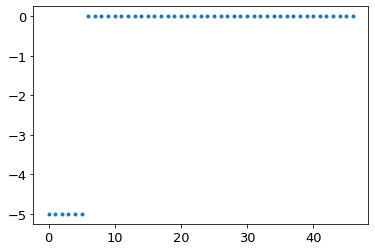

In [60]:
print(usa_sshs.shape)
plt.plot(usa_sshs[1000],'.')

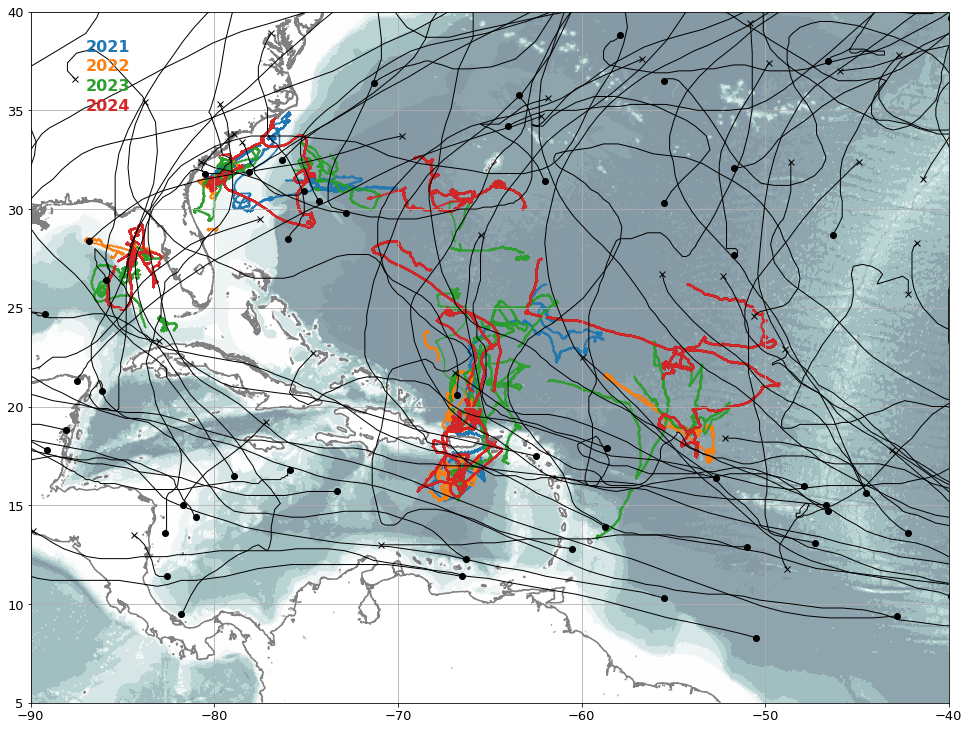

In [116]:
### plot tracks on map
ilon = np.where( lon_topo>= -100 )[0]
ilat = np.where( lat_topo>= 5 )[0]
cmap = truncate_colormap(plt.get_cmap('bone'),0.6,1)
cols = ['tab:blue','tab:orange','tab:green','tab:red']
### plot topography
fig = plt.figure(figsize=(15,12))
plt.rcParams.update({'font.size': 13})
ax2 = fig.add_axes([0.05,0,0.85,0.8])
levels_ocean = np.concatenate((np.arange(-5000,0,1000), np.arange(-200,100,100)))
cs = ax2.contourf(lon_topo[ilon], lat_topo[ilat], elevation[np.ix_(ilat,ilon)], cmap=cmap,levels=levels_ocean,extend='both')
ax2.contour(lon_topo[ilon], lat_topo[ilat], elevation[np.ix_(ilat,ilon)], colors='gray',levels=0)
### plot tracks - color by year
vars_str = ['longitude','latitude']
year_append = []
for i, file in enumerate( filenames ):
    ds = nc.Dataset(path_data + file)
    ### read lon/ lat from this position file
    for v in range( len(vars_str) ):
        exec(vars_str[v]+'= ds.variables["'+vars_str[v]+'"][:]')
    ### plot SD tracks
    year_this_file = file[14:18]
    icol = np.where( year == year_this_file )[0][0]
    if year_this_file not in year_append:
        year_append.append( year_this_file )
        ax2.text(-87,39-len(year_append),year_this_file,fontsize=16,color=cols[icol],fontweight='bold') #
    ax2.scatter( longitude, latitude, s=0.05,c=cols[icol])
### plot TC tracks 
for i in range( dtime_track.shape[0] ):
    year_this_track = str(dtime_track[i,0].year)
    if (year_this_track in year) & (basin[i,0,0] == b'N') & (basin[i,0,1] == b'A'):
        icol = np.where( year == year_this_track )[0][0]
        edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
        plt.plot( usa_lon[i,:], usa_lat[i,:], '-',color='k',lw=1)
        plt.plot( usa_lon[i,edge_ok[0]], usa_lat[i,edge_ok[0]],'o',color='k')
        plt.plot( usa_lon[i,edge_ok[1]], usa_lat[i,edge_ok[1]],'x',color='k')
### figure settings
ax2.set_xlim([-90,-40])
ax2.set_ylim([5,40])
ax2.grid()
### save figure
fig.savefig('map_SD-tracks_TC-tracks_'+'-'.join(year)+'.png', dpi=600,bbox_inches='tight')

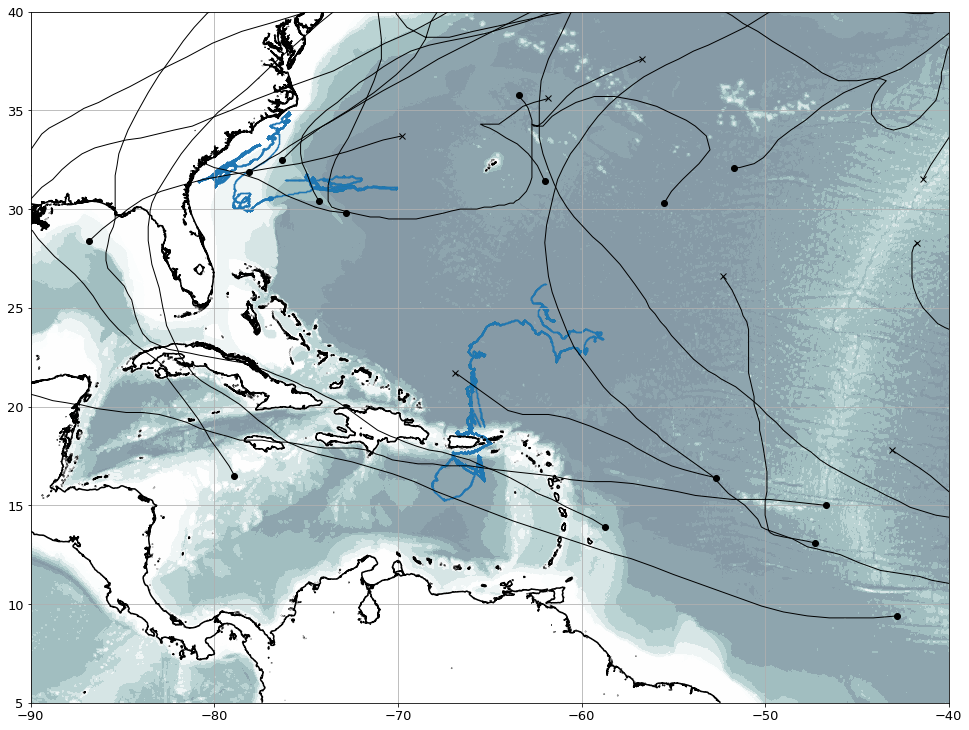

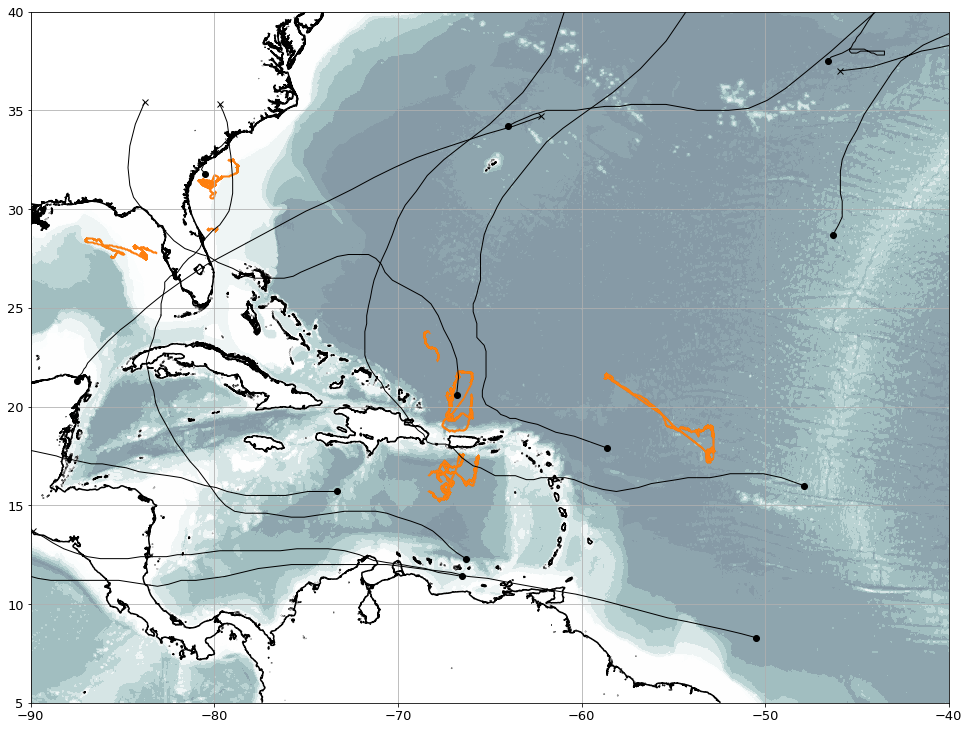

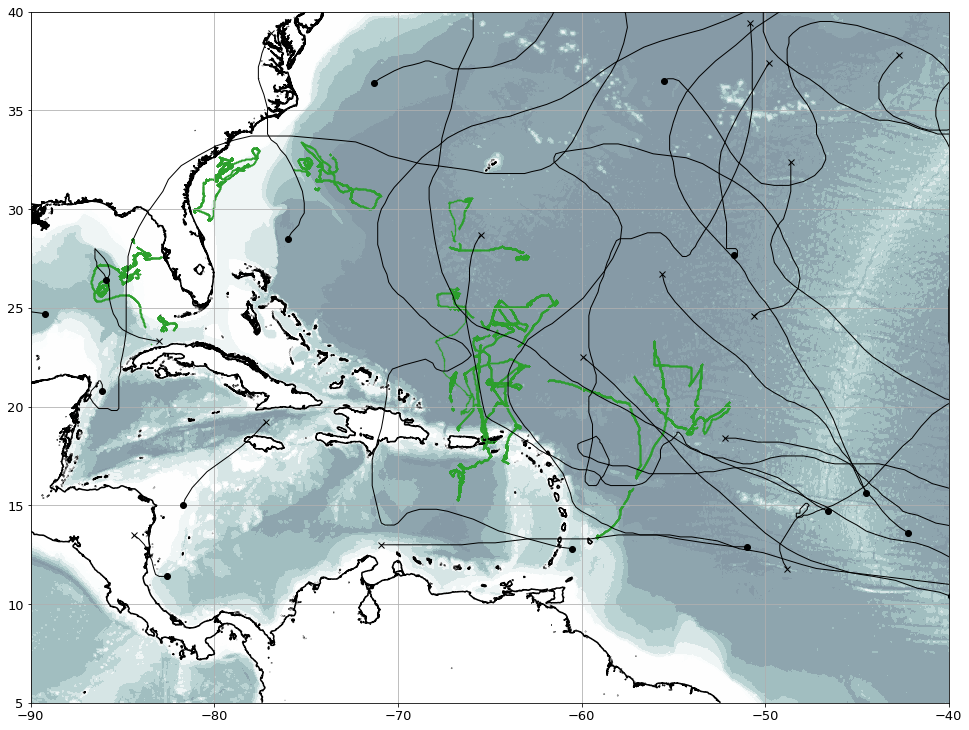

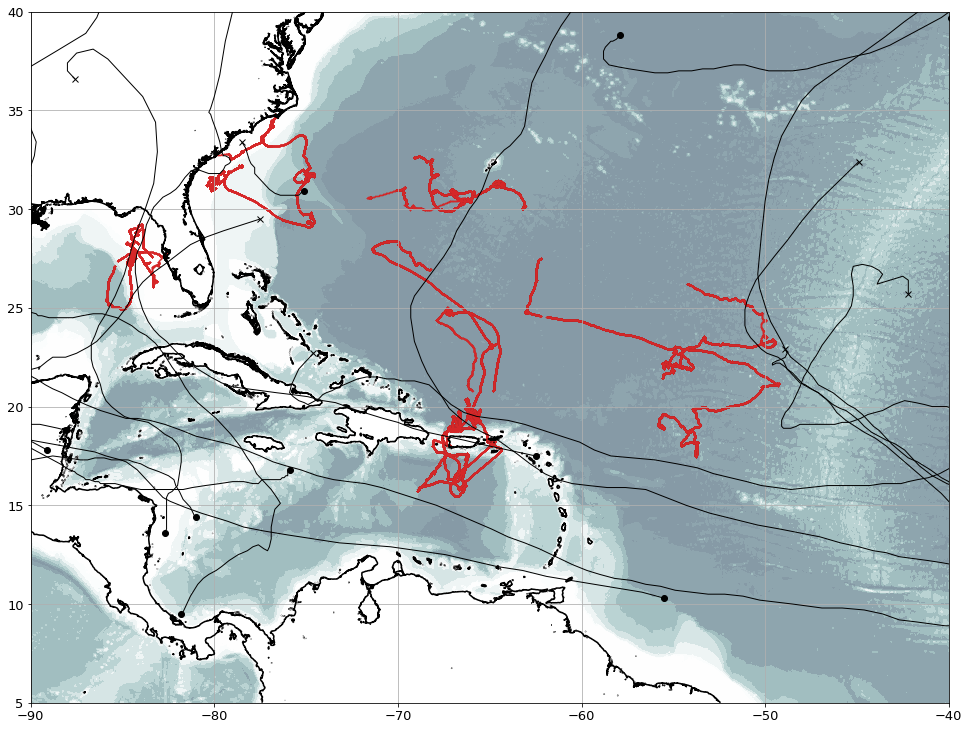

In [51]:
''' Plot one plot per year '''
### plot tracks on map
ilon = np.where( lon_topo>= -100 )[0]
ilat = np.where( lat_topo>= 5 )[0]
cmap = truncate_colormap(plt.get_cmap('bone'),0.6,1)
cols = ['tab:blue','tab:orange','tab:green','tab:red']

### plot topography
for year_this_plot in year:
    plt.clf()
    fig = plt.figure(figsize=(15,12))
    plt.rcParams.update({'font.size': 13})
    ax2 = fig.add_axes([0.05,0,0.85,0.8])
    levels_ocean = np.concatenate((np.arange(-5000,0,1000), np.arange(-200,100,100)))
    cs = ax2.contourf(lon_topo[ilon], lat_topo[ilat], elevation[np.ix_(ilat,ilon)], cmap=cmap,levels=levels_ocean,extend='both')
    ax2.contour(lon_topo[ilon], lat_topo[ilat], elevation[np.ix_(ilat,ilon)], colors='k',levels=0)
    ### plot tracks - color by year
    vars_str = ['longitude','latitude']
    for i, file in enumerate( filenames ):
        ds = nc.Dataset(path_data + file)
        ### read lon/ lat from this position file
        for v in range( len(vars_str) ):
            exec(vars_str[v]+'= ds.variables["'+vars_str[v]+'"][:]')
        ### plot SD tracks
        year_this_file = file[14:18]
        icol = np.where( year == year_this_file )[0][0]
        if year_this_file == year_this_plot:
            ax2.scatter( longitude, latitude, s=0.05,c=cols[icol])
    ### plot TC tracks 
    for i in range( dtime_track.shape[0] ):
        year_this_track = str(dtime_track[i,0].year)
        if (year_this_track == year_this_plot) & (basin[i,0,0] == b'N') & (basin[i,0,1] == b'A'):
            icol = np.where( year == year_this_track )[0][0]
            edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
            plt.plot( usa_lon[i,:], usa_lat[i,:], '-',color='k',lw=1)
            plt.plot( usa_lon[i,0], usa_lat[i,0],'o',color='k')
            plt.plot( usa_lon[i,edge_ok[1]], usa_lat[i,edge_ok[1]],'x',color='k')
    ### figure settings
    ax2.set_xlim([-90,-40])
    ax2.set_ylim([5,40])
    ax2.grid()
    ### save figure
    fig.savefig('map_SD-tracks_TC-tracks_'+year_this_plot+'.png', dpi=600,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

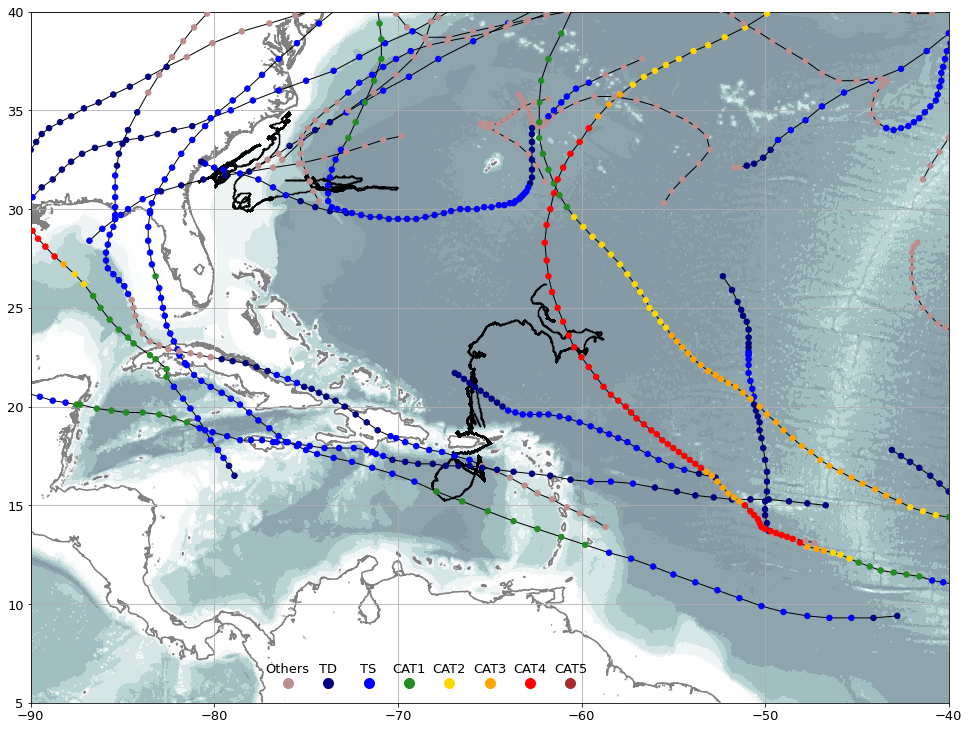

In [114]:
''' Plot TC tracks - colors in TC status. Plot one plot per year 
-5 unknown_type_XX 
-4 post_tropical_ET_EX_PT 
-3 misc_disturbances_WV_LO_DB_DS_IN_MD 
-2 subtropical_SS_SD 
-1 tropical_depression_w_lt_34 
0 tropical_storm_wind_35-63 
1 hurricane_cat_1_wind_64-82 
2 hurricane_cat_2_wind_83-95 
3 urricane_cat_3_wind_96-112 
4 hurricane_cat_4_wind_113-136 
5 hurricane_cat_5_wind_137+
'''
### plot tracks on map
ilon = np.where( lon_topo>= -100 )[0]
ilat = np.where( lat_topo>= 5 )[0]
cmap = truncate_colormap(plt.get_cmap('bone'),0.6,1)
sshs = np.arange(-5,6)
cols_sshs = ['rosybrown','rosybrown','rosybrown','rosybrown','navy','blue','forestgreen','gold','orange','red','brown']
strs_sshs = ['Others','TD','TS','CAT1','CAT2','CAT3','CAT4','CAT5']

### plot topography
for year_this_plot in year:
    plt.clf()
    fig = plt.figure(figsize=(15,12))
    plt.rcParams.update({'font.size': 13})
    ax2 = fig.add_axes([0.05,0,0.85,0.8])
    levels_ocean = np.concatenate((np.arange(-5000,0,1000), np.arange(-200,100,100)))
    cs = ax2.contourf(lon_topo[ilon], lat_topo[ilat], elevation[np.ix_(ilat,ilon)], cmap=cmap,levels=levels_ocean,extend='both',zorder=0)
    ax2.contour(lon_topo[ilon], lat_topo[ilat], elevation[np.ix_(ilat,ilon)], colors='gray',levels=0,zorder=1)
    ## plot tracks - color by year
    vars_str = ['longitude','latitude']
    for i, file in enumerate( filenames ):
        ds = nc.Dataset(path_data + file)
        ### read lon/ lat from this position file
        for v in range( len(vars_str) ):
            exec(vars_str[v]+'= ds.variables["'+vars_str[v]+'"][:]')
        ### plot SD tracks
        year_this_file = file[14:18]
        icol = np.where( year == year_this_file )[0][0]
        if year_this_file == year_this_plot:
            ax2.scatter( longitude, latitude, s=0.05,c='k', zorder=2)
    ### plot TC tracks 
    for i in range( dtime_track.shape[0] ):
        year_this_track = str(dtime_track[i,0].year)
        if (year_this_track == year_this_plot) & (basin[i,0,0] == b'N') & (basin[i,0,1] == b'A'):
            icol = np.where( year == year_this_track )[0][0]
            edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
            lon_ok = usa_lon[i,edge_ok[0]:edge_ok[1]+1]
            lat_ok = usa_lat[i,edge_ok[0]:edge_ok[1]+1]
            sshs_ok = usa_sshs[i,edge_ok[0]:edge_ok[1]+1]
            c_sshs_ok = []
            for j in sshs_ok+5:
                c_sshs_ok.append(cols_sshs[j])
            plt.plot( lon_ok, lat_ok, '-',color='k',lw=1,zorder=3)
            sc = plt.scatter( lon_ok, lat_ok, s=30, c=c_sshs_ok,zorder=4)
    ### plot TC category icons
    for i, str_sshs in enumerate(strs_sshs):
        plt.plot(-76+i*2.2, 6,'o',color=cols_sshs[i+3],ms=10)
        plt.text(-76+i*2.2, 6.4, str_sshs,color='k',ha='center',va='bottom')
    ### figure settings
    ax2.set_xlim([-90,-40])
    ax2.set_ylim([5,40])
    ax2.grid()
    ### save figure
    fig.savefig('map_SD-tracks_TC-tracks_'+year_this_plot+'.png', dpi=600,bbox_inches='tight')
    break

<Figure size 432x288 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

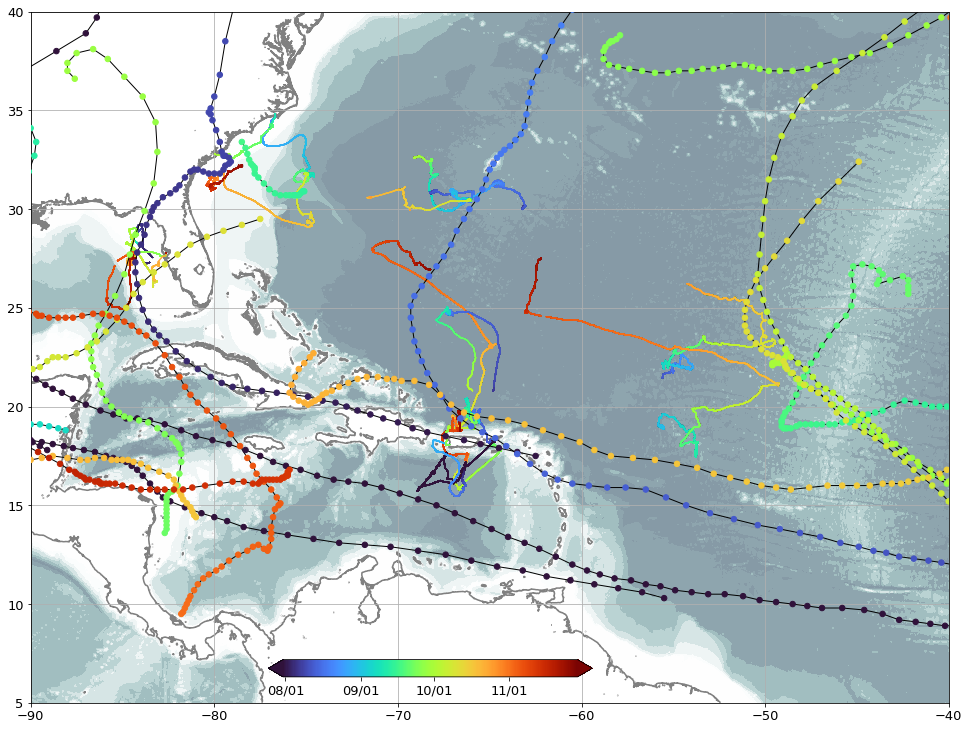

In [115]:
''' color both TC & SD tracks by time '''
### plot tracks on map
ilon = np.where( lon_topo>= -100 )[0]
ilat = np.where( lat_topo>= 5 )[0]
cmap = truncate_colormap(plt.get_cmap('bone'),0.6,1)
yday_lim = [213, 334]
cmap_yday = 'turbo'
### plot topography
for year_this_plot in year:
    plt.clf()
    fig = plt.figure(figsize=(15,12))
    plt.rcParams.update({'font.size': 13})
    ax2 = fig.add_axes([0.05,0,0.85,0.8])
    levels_ocean = np.concatenate((np.arange(-5000,0,1000), np.arange(-200,100,100)))
    cs = ax2.contourf(lon_topo[ilon], lat_topo[ilat], elevation[np.ix_(ilat,ilon)], cmap=cmap,levels=levels_ocean,extend='both',zorder=0)
    ax2.contour(lon_topo[ilon], lat_topo[ilat], elevation[np.ix_(ilat,ilon)], colors='gray',levels=0,zorder=1)
    ## plot tracks - color by year
    vars_str = ['time','longitude','latitude']
    for i, file in enumerate( filenames ):
        ds = nc.Dataset(path_data + file)
        ### read lon/ lat from this position file
        for v in range( len(vars_str) ):
            exec(vars_str[v]+'= ds.variables["'+vars_str[v]+'"][:]')
        dtime = np.array([datetime.datetime(int(year_this_plot),1,1)+datetime.timedelta(seconds=dt) for dt in time])
        _, yday = datetime_to_yearday(dtime)
        ### plot SD tracks
        year_this_file = file[14:18]
        icol = np.where( year == year_this_file )[0][0]
        if year_this_file == year_this_plot:
            ax2.scatter( longitude, latitude, s=0.05, c=yday, cmap=cmap_yday, vmin=yday_lim[0], vmax=yday_lim[1], zorder=2)
    ### plot TC tracks 
    for i in range( dtime_track.shape[0] ):
        year_this_track = str(dtime_track[i,0].year)
        if (year_this_track == year_this_plot) & (basin[i,0,0] == b'N') & (basin[i,0,1] == b'A'):
            icol = np.where( year == year_this_track )[0][0]
            edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
            lon_ok = usa_lon[i,edge_ok[0]:edge_ok[1]+1]
            lat_ok = usa_lat[i,edge_ok[0]:edge_ok[1]+1]
            sshs_ok = usa_sshs[i,edge_ok[0]:edge_ok[1]+1]
            c_sshs_ok = []
            for j in sshs_ok+5:
                c_sshs_ok.append(cols_sshs[j])
            dtime_ok = dtime_track[i,edge_ok[0]:edge_ok[1]+1]
            yday_ok = np.nan*np.ones( dtime_ok.shape )
            for j, dtime_this in enumerate(dtime_ok):
                if isinstance(dtime_this, datetime.datetime):
                    _,yday_ok[j] = datetime_to_yearday(dtime_this)
            plt.plot( lon_ok, lat_ok, '-',color='k',lw=1,zorder=3)
            sc = plt.scatter( lon_ok, lat_ok, s=30, c=yday_ok, cmap=cmap_yday, vmin=yday_lim[0], vmax=yday_lim[1], zorder=4)
    ### yday colorbar
    months = np.arange(8,12,1)
    dtime_ticks = np.array([datetime.datetime(int(year_this_plot),item,1) for item in months])
    _, yday_ticks = datetime_to_yearday(dtime_ticks)
    yday_ticklabels = [item.strftime('%m/%d') for item in dtime_ticks]
    axf = fig.add_axes([0.27,0.03,0.3,0.02])
    axf = plt.colorbar(sc,orientation='horizontal',cax=axf,extend='both')
    axf.set_ticks(yday_ticks)
    axf.set_ticklabels(yday_ticklabels)
    ### figure settings
    ax2.set_xlim([-90,-40])
    ax2.set_ylim([5,40])
    ax2.grid()
    # break
    ### save figure
    fig.savefig('map_SD-tracks_TC-tracks_'+year_this_plot+'_colorByYday.png', dpi=600,bbox_inches='tight')